<a href="https://colab.research.google.com/github/pooriaazami/deep_learning_class_notebooks/blob/main/9_Unet_and_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

In [ ]:
files.upload()

In [4]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tapakah68/supervisely-filtered-segmentation-person-dataset

100% 4.31G/4.31G [03:33<00:00, 22.8MB/s]
100% 4.31G/4.31G [03:33<00:00, 21.7MB/s]


In [ ]:
!unzip supervisely-filtered-segmentation-person-dataset.zip
!rm supervisely-filtered-segmentation-person-dataset.zip

In [7]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from IPython.display import clear_output

In [8]:
DF_PATH = 'df.csv'
ROOT = 'supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/'
IMAGE_SIZE = 300
BATCH_SIZE = 4
EPOCHS = 1

LR = 1e-3

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
class SegmentationDataset(Dataset):
  def __init__(self, df_path, root, transforms=None):
    self.df = pd.read_csv(df_path)
    self.__root = root
    self.__transforms = transforms

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    _, image_path, mask_path, _ =  self.df.iloc[idx]

    image_path = os.path.join(self.__root, image_path)
    mask_path = os.path.join(self.__root, mask_path)

    image = Image.open(image_path).convert(mode='RGB')
    mask = Image.open(mask_path).convert(mode='RGB').convert('L')

    if self.__transforms:
      image = self.__transforms(image)
      mask = self.__transforms(mask)

    return image, mask

In [10]:
dataset = SegmentationDataset(DF_PATH, ROOT)

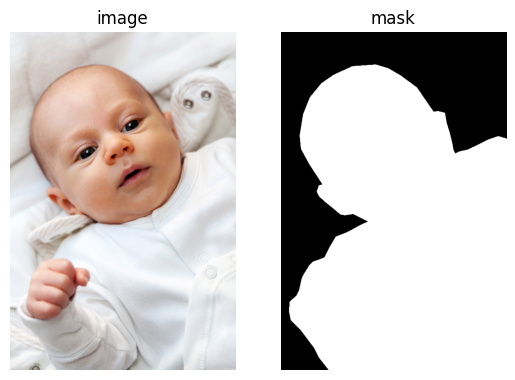

In [11]:
idx = 10
image, mask = dataset[idx]

fig, axs = plt.subplots(1, 2)

axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('image')

axs[1].imshow(mask, cmap='gray')
axs[1].axis('off')
axs[1].set_title('mask')

plt.show()

In [12]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv_blocks = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels),
    )

  def forward(self, x):
    return self.conv_blocks(x)

In [13]:
class DownBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.conv_blocks = nn.Sequential(
        nn.MaxPool2d(2),
        ConvBlock(in_channels, out_channels)
    )

  def forward(self, x):
    return self.conv_blocks(x)

In [14]:
class UpBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=2, stride=2)
    self.conv_blocks = ConvBlock(in_channels, out_channels)

  def forward(self, x, residual_inputs):
    x = self.up(x)

    diff_y = residual_inputs.size()[2] - x.size()[2] # (batch_size, channels, y, x)
    diff_x = residual_inputs.size()[3] - x.size()[3]

    x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2,
                  diff_y // 2, diff_y - diff_y // 2])

    x = torch.cat([residual_inputs, x], dim=1)
    x = self.conv_blocks(x)

    return x

In [15]:
class OutBlock(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=num_classes, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

In [16]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.input_block = ConvBlock(in_channels, 64)

    self.down_1 = DownBlock(64, 128)
    self.down_2 = DownBlock(128, 256)
    self.down_3 = DownBlock(256, 512)
    self.down_4 = DownBlock(512, 1024)

    self.up_4 = UpBlock(1024, 512)
    self.up_3 = UpBlock(512, 256)
    self.up_2 = UpBlock(256, 128)
    self.up_1 = UpBlock(128, 64)

    self.output_block = OutBlock(64, num_classes)

  def forward(self, x):
    down_cache_1 = self.input_block(x)

    down_cache_2 = self.down_1(down_cache_1)
    down_cache_3 = self.down_2(down_cache_2)
    down_cache_4 = self.down_3(down_cache_3)
    down_cache_5 = self.down_4(down_cache_4)

    x = self.up_4(down_cache_5, down_cache_4)
    x = self.up_3(x, down_cache_3)
    x = self.up_2(x, down_cache_2)
    x = self.up_1(x, down_cache_1)

    x = self.output_block(x)

    return x

In [17]:
model = UNet(in_channels=3, num_classes=1).to(DEVICE)

In [18]:
test_input = torch.zeros((10, 3, 128, 128)).to(DEVICE)
test_output = model(test_input)

test_output.shape

torch.Size([10, 1, 128, 128])

In [19]:
transforms = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor()
])

dataset = SegmentationDataset(DF_PATH, ROOT, transforms)

In [20]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [24]:
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_function = nn.BCEWithLogitsLoss()

In [25]:
def plot_sample(image, mask, clear=True):
  if clear:
    clear_output()
  fig, axs = plt.subplots(1, 2)

  mask = (mask.detach().cpu()[0, :, :, :].numpy().transpose((1, 2, 0)) > 0).astype(np.uint8)
  image = image.detach().cpu()[0, :, :, :].numpy().transpose((1, 2, 0))

  axs[0].imshow(image)
  axs[0].axis('off')
  axs[0].set_title('image')

  axs[1].imshow(mask, cmap='gray')
  axs[1].axis('off')
  axs[1].set_title('mask')

  plt.show()

  0%|          | 0/667 [00:00<?, ?it/s]

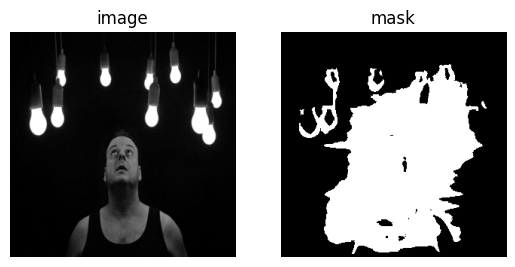

loss: 330.75


In [26]:
for i in range(EPOCHS):
  total_loss = .0
  for image, mask in tqdm(dataloader):
    optimizer.zero_grad()

    image = image.to(DEVICE)
    mask = mask.to(DEVICE)

    predicted_mask = model(image)
    loss = loss_function(predicted_mask, mask)

    loss.backward()
    optimizer.step()
    total_loss += loss.detach().cpu().item()

  plot_sample(image, predicted_mask, False)
  print(f'loss: {total_loss:.2f}')

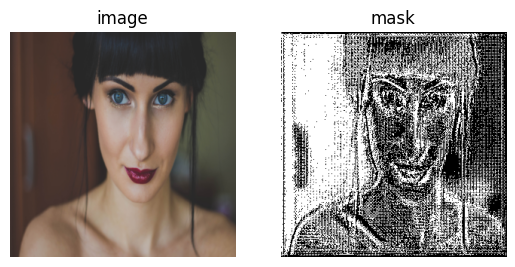